In [167]:
import numpy as np
from numpy.random import choice
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (14, 7)

In [100]:
plan_file = r"C:\Elie\Data\OT\color.plan"
output_lut_file = r"C:\Elie\Data\OT\color-plan.cube"
output_lut_file2 = r"C:\Elie\Data\OT\color-plan.nearest-neighbor.cube"
output_lut_file3 = r"C:\Elie\Data\OT\color-plan.torch.cube"

In [21]:
with open(plan_file, 'rb') as f:
    f.read(4)
    data = np.fromfile(f, dtype='d').reshape(-1,2,3)

In [58]:
subset = choice(data.shape[0], 100240, replace=False)
xdata = data[subset,0,:]
ydata = data[subset,1,:]

In [106]:
def export_lut(lut, filename):
    if type(lut) == torch.Tensor:
        lut = lut.detach().numpy()
    with open(filename, 'w') as f:
        f.write("LUT_3D_SIZE 64\n")
        for r,g,b in np.nan_to_num(lut, 0):
            f.write(f"{r:.04f} {g:.04f} {b:.04f}\n")

## Linear Interpolator

In [59]:
model = LinearNDInterpolator(xdata, ydata)

In [60]:
model([0,0,0])

array([[ 0.00256583,  0.00611796, -0.00902064]])

In [61]:
grid = np.mgrid[:64,:64,:64].transpose(3,2,1,0).reshape(-1,3) / (64 - 1)

In [62]:
model(grid)

array([[ 0.00256583,  0.00611796, -0.00902064],
       [ 0.01677362,  0.00773954, -0.00804585],
       [ 0.02657761,  0.0119001 , -0.00856904],
       ...,
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan]])

In [63]:
lut=_

In [67]:
with open(output_lut_file, 'w') as f:
    f.write("LUT_3D_SIZE 64\n")
    for r,g,b in np.nan_to_num(lut, 0):
        f.write(f"{r} {g} {b}\n")

## Nearest Neighbor Interpolator

In [74]:
model2 = NearestNDInterpolator(xdata, ydata)

In [78]:
lut = model2(grid)

In [80]:
with open(output_lut_file2, 'w') as f:
    f.write("LUT_3D_SIZE 64\n")
    for r,g,b in np.nan_to_num(lut, 0):
        f.write(f"{r:.04f} {g:.04f} {b:.04f}\n")

## Neural Networks

In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [155]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [114]:
tgrid = torch.from_numpy(grid.astype('f'))
txdata = torch.from_numpy(xdata.astype('f'))
tydata = torch.from_numpy(ydata.astype('f'))

In [684]:
class ColorTransferNet(nn.Module):
    def __init__(self, hidden=30):
        super().__init__()
        self.fc1 = nn.Linear(3, hidden)
        self.fc2init = nn.Linear(hidden, 3)
        for p in self.fc2init.parameters():
            p.requires_grad = False
        self.do1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden, 3)
        self.init = True
        
    def finish_init(self):
        self.init = False
        
    def forward(self, x):
        #x -= 0.5
        x = self.fc1(x)
        if self.init:
            x = self.fc2init(x)
            return x
        #x = torch.sigmoid(x)
        x = torch.relu(x)
        #x = self.do1(x)
        x = self.fc2(x)
        return x

In [685]:
model = ColorTransferNet(hidden=24).to(device)

In [686]:
lut = model(tgrid.to(device)).cpu()

In [687]:
export_lut(lut, output_lut_file3)

In [688]:
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.95)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.AdamW(model.parameters(), lr=5e-2)

In [689]:
loss_fn = nn.MSELoss(reduction='sum')

In [690]:
dataset = TensorDataset(txdata,tydata)
data_loader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
)

In [706]:
max_epochs = 20
loss_log = []
for epoch in range(max_epochs):
    tot_loss = 0.0
    iterations = 0
    for batch_ndx, sample in enumerate(data_loader):
        x, y = sample[0].to(device), sample[1].to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        tot_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iterations += 1
    tot_loss /= iterations
    loss_log.append(tot_loss)
    print(f"iteration #{epoch}: loss = {tot_loss}")

iteration #0: loss = 0.14497788434810177
iteration #1: loss = 0.1463130772760024
iteration #2: loss = 0.14511883002230708
iteration #3: loss = 0.14445480132209404
iteration #4: loss = 0.14495735615491867
iteration #5: loss = 0.1446895679763081
iteration #6: loss = 0.14513562260461704
iteration #7: loss = 0.1446232765114733
iteration #8: loss = 0.14451578014283156
iteration #9: loss = 0.14487026878917703
iteration #10: loss = 0.14479401834993338
iteration #11: loss = 0.1449712456337043
iteration #12: loss = 0.1439719196903158
iteration #13: loss = 0.14433447117632142
iteration #14: loss = 0.14366319387847062
iteration #15: loss = 0.1433882020337849
iteration #16: loss = 0.1436203381768903
iteration #17: loss = 0.14411291582699942
iteration #18: loss = 0.144199740103617
iteration #19: loss = 0.14390824362635612


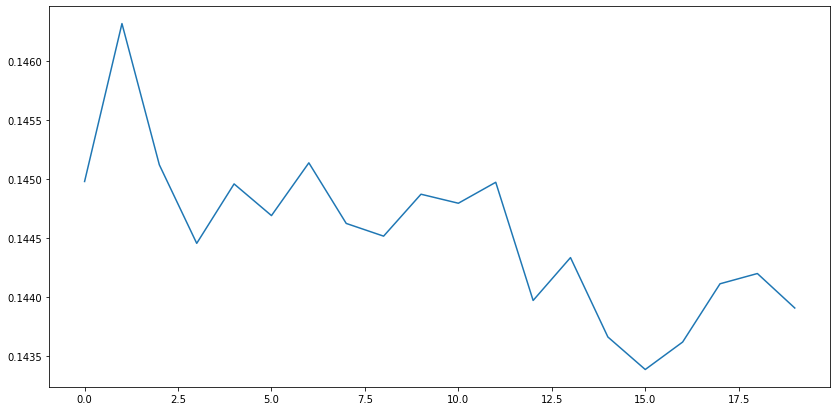

In [707]:
plt.plot(loss_log)
plt.show()

In [694]:
model.finish_init()

In [632]:
loss_log[-1]

1.0431222655639356

In [708]:
lut = model(tgrid.to(device)).cpu()

In [709]:
export_lut(lut, output_lut_file3)

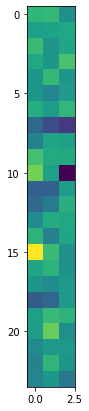

In [681]:
plt.imshow(model.fc1.weight.data.cpu().numpy())

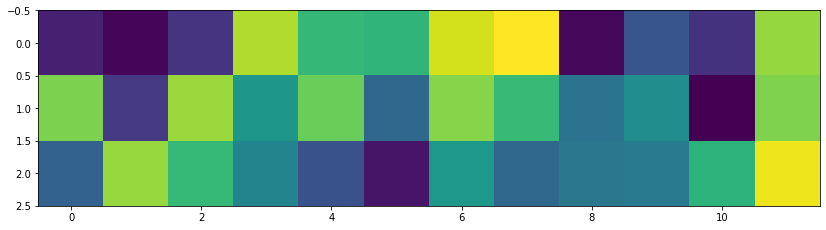

In [636]:
plt.imshow(model.fc2init.weight.data.cpu().numpy())

Une recette qui marche un peu (loss de .25) :  
24 neuronnes cachés, relu  
optimizer = optim.Adam(model.parameters(), lr=1e-3)  
et 10 étapes avant d'appeler model.finish_init()  
puis ensuite beaucoup d'étapes  

## More than one hidden layer

In [764]:
class ColorTransferNet2(nn.Module):
    def __init__(self, hidden=30):
        super().__init__()
        self.fc1 = nn.Linear(3, hidden)
        self.fc2init = nn.Linear(hidden, 3)
        for p in self.fc2init.parameters():
            p.requires_grad = False
        self.do1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 3)
        self.act = torch.sigmoid
        #self.act = F.relu
        self.init = True
        
    def finish_init(self):
        self.init = False
        
    def forward(self, x):
        x = self.fc1(x)
        if self.init:
            x = self.fc2init(x)
            return x
        x = self.act(x)
        #x = self.do1(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x

In [765]:
model = ColorTransferNet2(hidden=12).to(device)

In [766]:
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.95)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.AdamW(model.parameters(), lr=5e-2)

In [767]:
def train_epoch():
    tot_loss = 0.0
    iterations = 0
    for batch_ndx, sample in enumerate(data_loader):
        x, y = sample[0].to(device), sample[1].to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        tot_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iterations += 1
    return tot_loss / iterations

In [801]:
max_epochs = 200
loss_log = []
for epoch in range(max_epochs):
    tot_loss = train_epoch()
    loss_log.append(tot_loss)
    print(f"iteration #{epoch}: loss = {tot_loss}")

iteration #0: loss = 0.04473457731572645
iteration #1: loss = 0.04466511527722587
iteration #2: loss = 0.0448086886923304
iteration #3: loss = 0.0448881804952588
iteration #4: loss = 0.04472611390282305
iteration #5: loss = 0.0444883762108048
iteration #6: loss = 0.044759936578457754
iteration #7: loss = 0.04459629032038608
iteration #8: loss = 0.0445612440912091
iteration #9: loss = 0.044470819340524624
iteration #10: loss = 0.044432889869702716
iteration #11: loss = 0.044170685497359655
iteration #12: loss = 0.04462002715742101
iteration #13: loss = 0.04434664740360209
iteration #14: loss = 0.04431508249622219
iteration #15: loss = 0.04442071608666863
iteration #16: loss = 0.04425190230451372
iteration #17: loss = 0.04390986139734029
iteration #18: loss = 0.04409351941122084
iteration #19: loss = 0.043812568004870295
iteration #20: loss = 0.04399321017292689
iteration #21: loss = 0.043880294557014594
iteration #22: loss = 0.04411833078068282
iteration #23: loss = 0.04379948390153598


iteration #192: loss = 0.03886202541750153
iteration #193: loss = 0.03899837558975025
iteration #194: loss = 0.03896321668004503
iteration #195: loss = 0.038975703430229
iteration #196: loss = 0.03892277305641649
iteration #197: loss = 0.0388570551247317
iteration #198: loss = 0.03877913665349538
iteration #199: loss = 0.03894426058787776


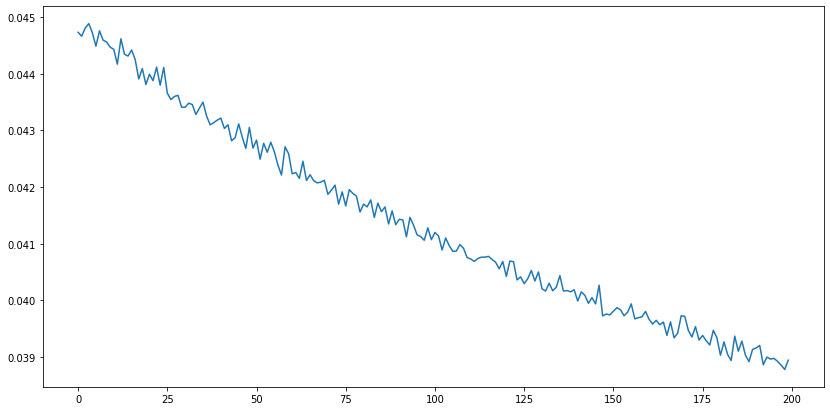

In [802]:
plt.plot(loss_log)
plt.show()

In [774]:
model.finish_init()

In [803]:
lut = model(tgrid.to(device)).cpu()
export_lut(lut, output_lut_file3)